# Predict hoax using scaled features

Goal: Match or surpass the $R^2$ achieved with unscaled features

### notes

#### ➜ Fewer coefficients present without scaling. Why?

- There was a typo and a feature slipped through that wasn't supposed to
    - ➜ fixed
    - The sets are the same now, but the phenomenon is remaining.
- Maybe it's because the intercept was scaled to zero?  
    - ➜ Try only scaling the original floats.
    - Score improved to .54/.5 , but unscaled remains .6
- Look at (unscaled_coeff / $\sigma$) to understand feature importance
    - ➜ Try repeating the regression with these features only
    - Score improved to .55/.5 , and unscaled remains .58
- Checked Lasso (with all features)
    - ➜ same results as Ridge: .54/.5
- Relaxed my limitation of C,
    - ➜ improved to .57/.5 with C=6
- Ran logistic regression on unscaled features with no regularization
    - ➜ improved to .61/.5
    - Far out-performed the paper-author's models
- Let's try SFS with scaled features
    - Success!

## exploration controls

In [16]:
random_seed = 0

## get data

### imports

In [17]:
import os, re, patsy
import pandas as pd, numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
path = '/home/bhrdwj/git/predwikt/data/raw/wiki_reliability/unzipped/'

In [18]:
fea = (pd.read_csv(path+'hoax_features.csv', usecols=lambda x: x not in ['Unnamed: 0'])
       .rename(columns={'headings_by_level(2)':'headings_by_level_2', 'revision_id.key':'revision_id_key'}))

### train test split

#### Make series of negative revisions and their revision keys, and vice versa

In [19]:
neg_revs = fea[['revision_id', 'revision_id_key', 'has_template']]
neg_revs = neg_revs.loc[neg_revs.has_template==0].set_index('revision_id')['revision_id_key']
pos_revs = fea[['revision_id', 'revision_id_key', 'has_template']]
pos_revs = pos_revs.loc[pos_revs.has_template==1].set_index('revision_id')['revision_id_key']

neg_revs.shape #, pos_revs.shape

(1390,)

#### Test-train split the neg_revs, and form dfte and dftr

In [20]:
neg_revs_tr, neg_revs_te = train_test_split(neg_revs, test_size=.2, random_state=0)
pos_revs_tr = pos_revs[neg_revs_tr.values]
pos_revs_te = pos_revs[neg_revs_te.values]

In [21]:
revs_tr = pd.concat((neg_revs_tr, pos_revs_tr))
revs_te = pd.concat((neg_revs_te, pos_revs_te))

In [22]:
fea_rev = fea.set_index('revision_id')
dftr = fea_rev.loc[revs_tr.index].dropna()
dfte = fea_rev.loc[revs_te.index].dropna()

In [23]:
del neg_revs, pos_revs, neg_revs_tr, pos_revs_tr, neg_revs_te, pos_revs_te, revs_tr, revs_te, fea_rev

In [24]:
dftr[dftr.columns.difference(['page_id','revision_id_key','has_template'])].describe().T.sort_values(by='mean');

### prep

In [25]:
# remove non-features; onehotify categoricals
ytr = dftr.has_template
Xtr = dftr[dftr.columns.difference(['page_id','revision_id_key','has_template'])]
Xtr = patsy.dmatrix('~ '+' + '.join(Xtr.columns), data=Xtr, NA_action='drop', return_type='dataframe')

yte = dfte.has_template
Xte = dfte[dfte.columns.difference(['page_id','revision_id_key','has_template'])]
Xte = patsy.dmatrix('~ '+' + '.join(Xte.columns), data=Xte, NA_action='drop', return_type='dataframe')

# make complete list of columns in case the test set doesn't include any of a rare class
Xcols = list(
    set(Xtr.columns.tolist())
    .union(set(Xte.columns.tolist()))
)

for col in Xcols:
    if col not in Xte:
        Xte[col] = 0
    if col not in Xtr:
        Xtr[col] = 0
        
Xtr = Xtr.reindex(columns=Xcols)
Xte = Xte.reindex(columns=Xcols)

In [26]:
Xtr.shape, Xte.shape

((2221, 25), (556, 25))

## pipelines

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from mlxtend.feature_selection import SequentialFeatureSelector

## Custom gridsearch for feature & hyperparameter selection

### Why not use sklearn's GridSearchCV?

- It is possible to get out multiple feature sets at different steps from 0 to k, but only from the SFS run that GridSearch decided was optimal.
- By the time I go to the trouble to extract all the feature sets, I might as well do my own gridsearch too.

#### Previous thoughts on why not to use sklearn's GridSearchCV with SFS:

### imports

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### not using it rn

##### line-by-line of function

##### remove duplicate featuresets

### functions

##### get_fitfeats_sfs_pipe

In [282]:
def get_fitfeats_sfs_pipe(Xtr, ytr, pipe, param_grid:dict):
    """
    Args:
        Xtr: pd.DataFrame of features
        ytr: pd.Series target
        pipe: sklearn Pipeline ending in a mlxtend SequentialFeatureSelector instance.
        param_grid: dict of lists, params of pipe, input for sklearn ParameterGrid
    Returns:
        dict:
        - keys are numbers starting in 1, for each cell of ParameterGrid
        - values are lists of feature names
    """
    print(f'start time: {dt.now()}')
    pg = {i:j for i,j in enumerate(ParameterGrid(param_grid), start=1)}
    sfs_featdict = {}
    sfs_scoredict = {}
    for i in pg:
        pipe.set_params(**pg[i]).fit(Xtr, ytr)
        k_feats = pg[i]['sfs__k_features']
        idx_tup = pipe.steps[-1][1].get_metric_dict()[k_feats]['feature_idx']
        d = {k:list(v['feature_idx']) for k,v in pipe.steps[1][1].subsets_.items()}  # change pipe.steps[1] to directly look for the sfs step
        s = {k:v['avg_score'] for k,v in pipe.steps[1][1].subsets_.items()}  # change pipe.steps[1] to directly look for the sfs step
        for j in d: d[j] = Xtr.columns[d[j]]
        sfs_featdict[i] = d
        sfs_scoredict[i] = s
    print(f'finish time: {dt.now()}')
    return sfs_featdict, sfs_scoredict

### instances

In [283]:
scaler = StandardScaler()
lr_sfs = LogisticRegression(penalty='l2', max_iter=1000, fit_intercept=True)
sfs = SFS(estimator=lr_sfs, forward=True, floating=False, scoring='accuracy', cv=5)
sffs = SFS(estimator=lr_sfs, forward=True, floating=True, scoring='accuracy', cv=5)
sfbs = SFS(estimator=lr_sfs, forward=False, floating=True, scoring='accuracy', cv=5)
sfs_pipe = Pipeline([('scaler', scaler),('sfs', sfs)])

### fit

#### sffs

In [284]:
sfs_pipe_param_grid = {
    'sfs': [sffs, sfbs],
    'sfs__k_features': [1, len(Xtr.columns)],
    'sfs__estimator__C': [.1]
}

sfs_featdict, sfs_scoredict = get_fitfeats_sfs_pipe(Xtr, ytr, sfs_pipe, sfs_pipe_param_grid)

start time: 2021-12-28 19:45:52.518545
finish time: 2021-12-28 19:48:48.069153


### extract feats

In [66]:
sfs_feat_set = set()
sfs_kfeats_set = set()
for i in sfs_featdict:              # runs
    for j in sfs_featdict[i]:       # kfeats
        sfs_feat_set = sfs_feat_set.union(set(sfs_featdict[i][j]))
        sfs_kfeats_set = sfs_kfeats_set.union(set([j]))

In [67]:
sfs_feats = list(sfs_feat_set)
sfs_runs = list(sfs_featdict.keys())
sfs_kfeats = list(sfs_kfeats_set)

##### organize index as feature names

In [269]:
col = pd.MultiIndex.from_tuples(
    [(j,k) for j in sfs_runs for k in sfs_featdict[j]])
idx = pd.Index(sfs_feats, name='feature')
df = pd.DataFrame('-', idx, col)

#### insert occurence onehots for features

In [216]:
for i in sfs_feats:                             # feats
    for j in sfs_runs:                          # runs
        for k in sfs_featdict[j]:             # steps within run
            df.loc[i,(j,k)] = int(i in sfs_featdict[j][k])
df = df.astype(int)            

#### sort the index of features

##### count occurrences of features to sort the index

In [217]:
idx = pd.IndexSlice
sfs_feat_usecounts = df.loc[:,idx[1,:]].sum(axis=1)
for i in range(2,5):
    sfs_feat_usecounts += df.loc[:,idx[i,:]].sum(axis=1)

##### sort features by frequency of occurence in sfs cases

In [218]:
df = df.reindex(index=sfs_feat_usecounts.sort_values(ascending=False).index)
df = df.sort_index(axis=1)

In [219]:
df1 = df.loc[:,idx[2,:]].T.droplevel(level=0).T

### visualize

##### imports

In [ ]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

#### plot feature selection

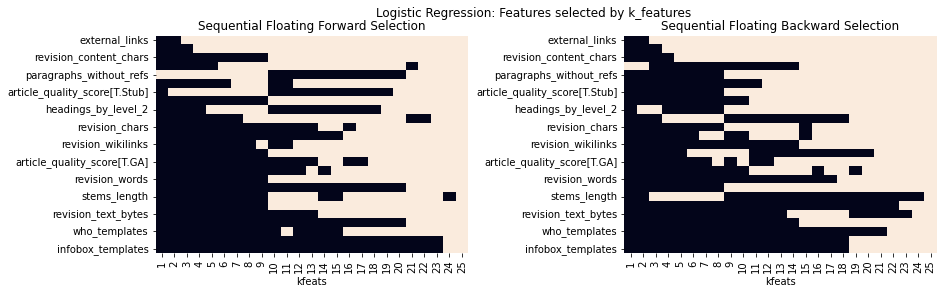

In [268]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
fig.subplots_adjust(wspace=.5)

(sns.heatmap(
    df.loc[:,idx[2,:]].T.droplevel(level=0).T, 
    ax=ax[0], cbar=False)
    .set(ylabel=None, xlabel='kfeats')   
)
(sns.heatmap(
    df.loc[:,idx[3,:]].T.droplevel(level=0).T, 
    ax=ax[1], cbar=False)
    .set(ylabel=None, xlabel='kfeats')
)

ax[0].set_title('Sequential Floating Forward Selection')
ax[1].set_title('Sequential Floating Backward Selection')
fig.suptitle('Logistic Regression: Features selected by k_features')
fig.show()

##### check the sort

In [ ]:
import seaborn as sns
sns.heatmap(df.reset_index())

In [190]:
df1 = df.copy()
df1.columns = df1.columns.droplevel(0)
df1 = df1.T
df1 = df1.drop_duplicates().reset_index(drop=True)
df1 = df1.T
df1

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
feature,,,,,,,,,,,,,,,,,,,,,
external_links,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
revision_templates,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
revision_content_chars,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
words_to_watch_matches,0,0,0,0,0,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
paragraphs_without_refs,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
shortened_footnote_templates,0,0,0,0,0,0,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
article_quality_score[T.Stub],0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
cite_templates,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
headings_by_level_2,0,0,0,0,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1


#### tune hyperparams

In [ ]:
best_Cs = {}
test_scores = {}
for i in sfs_dict:
    lr_C = LogisticRegressionCV(penalty='l2', Cs=[.01,.1,1,10,100], max_iter=1000, fit_intercept=True)
    lr_C.fit(Xtr[Xtr.columns[sfs_dict[i]]], ytr)
    best_Cs[i] = lr_C.C_[0]
    test_scores[i] = lr_C.score(Xte[sfs_dict[i]], yte)

In [348]:
best_Cs = pd.Series(best_Cs, name='best_C')
test_scores=pd.Series(test_scores, name='test_scores')
df = pd.concat((df, pd.concat((best_Cs, test_scores), axis=1).T), axis=0)

In [364]:
df

,1,2,3,4,5
revision_templates,1,1,1,1,1
paragraphs_without_refs,1,1,1,1,1
external_links,1,1,1,1,1
article_quality_score[T.Stub],1,1,1,1,1
headings_by_level_2,0,1,1,1,1
words_to_watch_matches,0,1,1,1,1
shortened_footnote_templates,0,0,1,1,1
article_quality_score[T.Start],0,0,1,1,1
revision_wikilinks,0,0,0,1,1
images_in_tags,0,0,0,1,1
